In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import sys
sys.path.append('../../..')
from contrib.DMI.ASIP_OSISAF.data import *
from contrib.DMI.ASIP_OSISAF.load_data import *
from src.utils import *
from src.models import *

import matplotlib.pyplot as plt
import torch
import itertools
import geopandas as gpd
from geopandas import GeoSeries
import cartopy.feature as cfeature

datamodule = BaseDataModule(asip_paths=load_data(),
                            osisaf_paths=load_data(type="osisaf"),
                            domains={'train': {'time': slice('2022-01-01', '2023-12-31',)},
                                     'val': {'time': [ slice('2021-01-01', '2021-06-30',),
                                                       slice('2021-07-01', '2021-12-31',) ]},
                                     'test': {'time': slice('2024-01-01', '2024-01-20',)}},
                            xrds_kw={'patch_dims': {'time': 19, 'yc': 240, 'xc': 240},
                                     'strides': {'time': 1, 'yc': 20, 'xc': 20},
                                     'strides_test': {'time': 1, 'yc': 200, 'xc': 200},
                                     'domain_limits':  dict(xc=slice(-3849750.,3749750.,),
                                                            yc=slice(5849750.,-5349750.,))
                                     },
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            res=500,
                            pads=[False,False,True],
                            norm_stats =[50,38])
datamodule.setup()

data_loader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()
test_dataloader = datamodule.test_dataloader()

#k=10
#my_sample = next(itertools.islice(data_loader, k, None))
#print(my_sample[0].shape)

/dmidata/users/maxb/miniconda3/envs/4dvarnet-starter/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


{'time': 729, 'xc': 15200, 'yc': 22400}
{'time': 180, 'xc': 15200, 'yc': 22400}
{'time': 183, 'xc': 15200, 'yc': 22400}
{'time': 19, 'xc': 15240, 'yc': 22440}


In [3]:
lon = xr.open_dataset(datamodule.train_ds.asip_paths[0]).lon.values
lat = xr.open_dataset(datamodule.train_ds.asip_paths[0]).lat.values
xc = xr.open_dataset(datamodule.train_ds.asip_paths[0]).xc.values
yc = xr.open_dataset(datamodule.train_ds.asip_paths[0]).yc.values
def find_idx(coords,c):
    return np.where(coords==c)[0][0]

In [ ]:
coords = datamodule.train_ds.get_coords()

k = 1
data = datamodule.train_ds[k]

ix = [find_idx(xc,x) for x in coords[k].xc.values]
iy = [find_idx(yc,y) for y in coords[k].yc.values]

ds = xr.Dataset(data_vars={'sic':(('time','yc','xc'),data.coarse)},
               coords={'time':np.arange(19),
                   'lon':(["yc","xc"], lon[iy[0]:(iy[-1]+1),ix[0]:(ix[-1]+1)]),
                   'lat':(["yc","xc"], lat[iy[0]:(iy[-1]+1),ix[0]:(ix[-1]+1)])})

p = ds.sic.plot(transform=ccrs.PlateCarree(),
                col='time',col_wrap=19,
                #aspect=datamodule.input_da.dims['lon'] / datamodule.input_da.dims['lat'],
                subplot_kws={'projection': ccrs.NorthPolarStereo()})
"""
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.set_global()
    ax.gridlines()
    ax.set_extent([np.min(ds.lon.values),
                   np.max(ds.lon.values),
                   np.min(ds.lat.values),
                   np.max(ds.lat.values)], crs=ccrs.PlateCarree())
"""

In [ ]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample 

map_proj = ccrs.NorthPolarStereo()
map_proj._threshold /= 100.

fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

sic = xr.open_dataset(datamodule.train_ds.asip_paths[100]).sic[0]
ax.pcolormesh(lon,lat,sic,transform=ccrs.PlateCarree())

# 1. Display the patch strategy

## 1.1 Plot the training batches

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



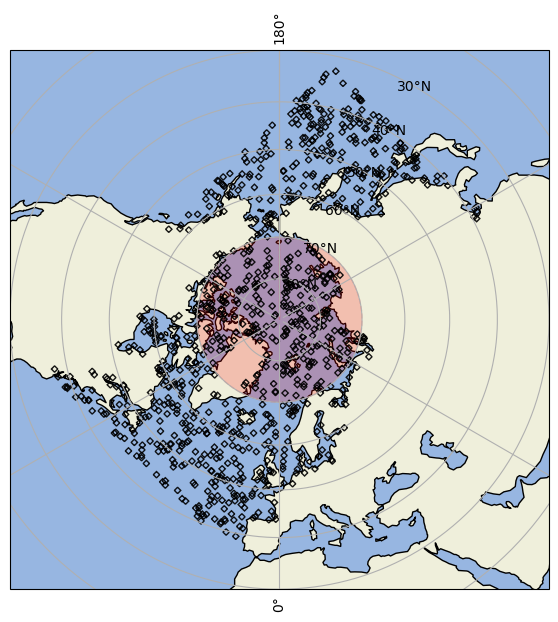

In [10]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample 

map_proj = ccrs.NorthPolarStereo()
map_proj._threshold /= 100.

fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

#coords = datamodule.train_ds.get_coords(limit=10000)
print(coords)

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[-180, 70], width=360, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.2,
                                    facecolor="red",
                                    transform=ccrs.PlateCarree()))

for k in sample(range(0,10000),1000):
    nxc = len(coords[k].xc.values)
    nyc = len(coords[k].yc.values)
    x = np.hstack((coords[k].xc.values,
                   np.repeat(coords[k].xc.values[-1],nyc),
                   np.flip(coords[k].xc.values),
                   np.repeat(coords[k].xc.values[0],nyc)))
    y = np.hstack((np.repeat(coords[k].yc.values[0],nxc),
                   coords[k].yc.values,
                   np.repeat(coords[k].yc.values[-1],nxc),
                   np.flip(coords[k].yc.values)))
    xy = np.vstack((x,y)).T
    klon = lon[[find_idx(yc,y) for y in xy[:,1]],
               [find_idx(xc,x) for x in xy[:,0]]]
    klat = lat[[find_idx(yc,y) for y in xy[:,1]],
               [find_idx(xc,x) for x in xy[:,0]]]
    lonlat = np.vstack((klon,klat)).T
    if ( np.all(np.sign(klon)==1) or np.all(np.sign(klon)==-1) ): 
        ax.add_patch(mpatches.Polygon(xy=lonlat, 
                                  closed=True,
                                  edgecolor='black',
                                  facecolor="none",
                                  alpha=0.9,
                                  transform=ccrs.PlateCarree()))      
plt.show()

## 1.2 Plot the validation batches

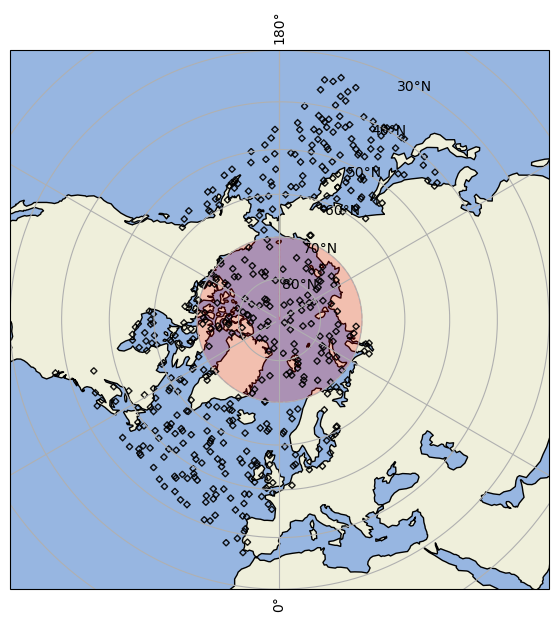

In [10]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample 

map_proj = ccrs.NorthPolarStereo()
map_proj._threshold /= 100.

fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

coords = datamodule.val_ds.datasets[0].get_coords(limit=1000)
coords += datamodule.val_ds.datasets[1].get_coords(limit=1000)

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[-180, 70], width=360, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.2,
                                    facecolor="red",
                                    transform=ccrs.PlateCarree()))

for k in sample(range(0,1000),500):
    nxc = len(coords[k].xc.values)
    nyc = len(coords[k].yc.values)
    x = np.hstack((coords[k].xc.values,
                   np.repeat(coords[k].xc.values[-1],nyc),
                   np.flip(coords[k].xc.values),
                   np.repeat(coords[k].xc.values[0],nyc)))
    y = np.hstack((np.repeat(coords[k].yc.values[0],nxc),
                   coords[k].yc.values,
                   np.repeat(coords[k].yc.values[-1],nxc),
                   np.flip(coords[k].yc.values)))
    xy = np.vstack((x,y)).T
    klon = lon[[find_idx(yc,y) for y in xy[:,1]],
               [find_idx(xc,x) for x in xy[:,0]]]
    klat = lat[[find_idx(yc,y) for y in xy[:,1]],
               [find_idx(xc,x) for x in xy[:,0]]]
    lonlat = np.vstack((klon,klat)).T
    if ( np.all(np.sign(klon)==1) or np.all(np.sign(klon)==-1) ): 
        ax.add_patch(mpatches.Polygon(xy=lonlat, 
                                  closed=True,
                                  edgecolor='black',
                                  facecolor="none",
                                  alpha=0.9,
                                  transform=ccrs.PlateCarree()))      
plt.show()

## 1.3 Plot the testing batches

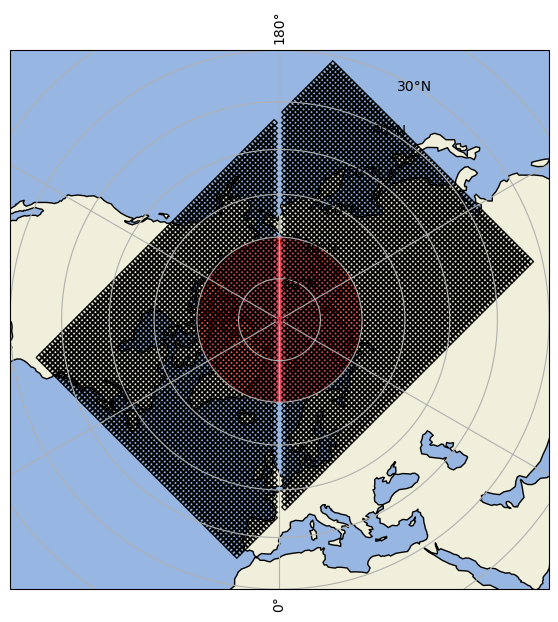

In [8]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample 

map_proj = ccrs.NorthPolarStereo()
map_proj._threshold /= 100.

xc = datamodule.test_ds.xc
yc = datamodule.test_ds.yc

fig, ax = plt.subplots(figsize=(8,7),
                       subplot_kw=dict(projection=map_proj))
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

coords = datamodule.test_ds.get_coords()

# Baltic
ax.add_patch(mpatches.Rectangle(xy=[-180, 70], width=360, height=20,
                                    edgecolor='red',
                                    linestyle="dashed",
                                    alpha=0.6,
                                    facecolor="red",
                                    transform=ccrs.PlateCarree()))

for k in range(len(coords)):
    nxc = len(coords[k].xc.values)
    nyc = len(coords[k].yc.values)
    x = np.hstack((coords[k].xc.values,
                   np.repeat(coords[k].xc.values[-1],nyc),
                   np.flip(coords[k].xc.values),
                   np.repeat(coords[k].xc.values[0],nyc)))
    y = np.hstack((np.repeat(coords[k].yc.values[0],nxc),
                   coords[k].yc.values,
                   np.repeat(coords[k].yc.values[-1],nxc),
                   np.flip(coords[k].yc.values)))
    xy = np.vstack((x,y)).T
    try:
        klon = lon[[find_idx(yc,y) for y in xy[:,1]],
               [find_idx(xc,x) for x in xy[:,0]]]
        klat = lat[[find_idx(yc,y) for y in xy[:,1]],
               [find_idx(xc,x) for x in xy[:,0]]]
        lonlat = np.vstack((klon,klat)).T
        if ( np.all(np.sign(klon)==1) or np.all(np.sign(klon)==-1) ): 
            ax.add_patch(mpatches.Polygon(xy=lonlat, 
                                  closed=True,
                                  edgecolor='black',
                                  facecolor="none",
                                  alpha=0.9,
                                  transform=ccrs.PlateCarree())) 
    except:
        pass
plt.show()

# 2. Load the model and run

In [5]:
device = 'cuda'
from contrib.DMI.ASIP_OSISAF.solver import *
from contrib.DMI.ASIP_OSISAF.UNet import *

solver = GradSolver(n_step=15,
                     lr_grad=1e3,
                      prior_cost = SRNNPriorCost(srnn=UNet(in_channels=19,
                                                      num_classes=19)),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=19,dim_hidden=96)).to(device)

/dmidata/users/maxb/4dvarnet-starter/Notebooks/Notebook_DMI/ASIP_OSISAF/../../../contrib/DMI/ASIP_OSISAF/UNet.py:210: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  init.xavier_normal(m.weight)
/dmidata/users/maxb/4dvarnet-starter/Notebooks/Notebook_DMI/ASIP_OSISAF/../../../contrib/DMI/ASIP_OSISAF/UNet.py:211: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias, 0)


## 2.1 Define the parameters

In [6]:
from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm

rec_weight = get_last_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                crop= {'time': 0, 'lat': 20, 'lon': 20}, offset=1,
                                dim_order=["time","yc","xc"])
rec_weight = torch.from_numpy(rec_weight).to(device)

optim_weight = get_linear_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'yc': datamodule.xrds_kw['patch_dims']['yc'],
                                                'xc': datamodule.xrds_kw['patch_dims']['xc']},
                                   crop= {'time': 0, 'yc': 20, 'xc': 20}, offset=1,
                                   dim_order=["time","yc","xc"])
optim_weight = torch.from_numpy(optim_weight).to(device)

sr_weight = get_uniform_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time'],
                                                'yc': datamodule.xrds_kw['patch_dims']['yc'],
                                                'xc': datamodule.xrds_kw['patch_dims']['xc']},
                                   crop= {'time': 0, 'yc': 20, 'xc': 20}, offset=1,
                                   dim_order=["time","yc","xc"])
sr_weight = torch.from_numpy(sr_weight).to(device)

def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.05:
        return None, None

    loss, out = base_step(batch)
    
    grad_loss = weighted_mse(kfilts.sobel(out) - kfilts.sobel(batch.tgt), optim_weight)
    srnn_loss = weighted_mse(batch.tgt-solver.prior_cost.forward_ae(batch.coarse.nan_to_num()), sr_weight)
    training_loss = 50*loss  + 10000 * grad_loss + 10 * srnn_loss
    print(50*loss, 10000 * grad_loss, 10 * srnn_loss)
    
    return training_loss, out

def base_step(batch):

    out = solver(batch=batch)
    # mse loss
    loss = weighted_mse(out - batch.tgt, optim_weight)
    return loss, out
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

  0%|                                                    | 0/10 [00:00<?, ?it/s]

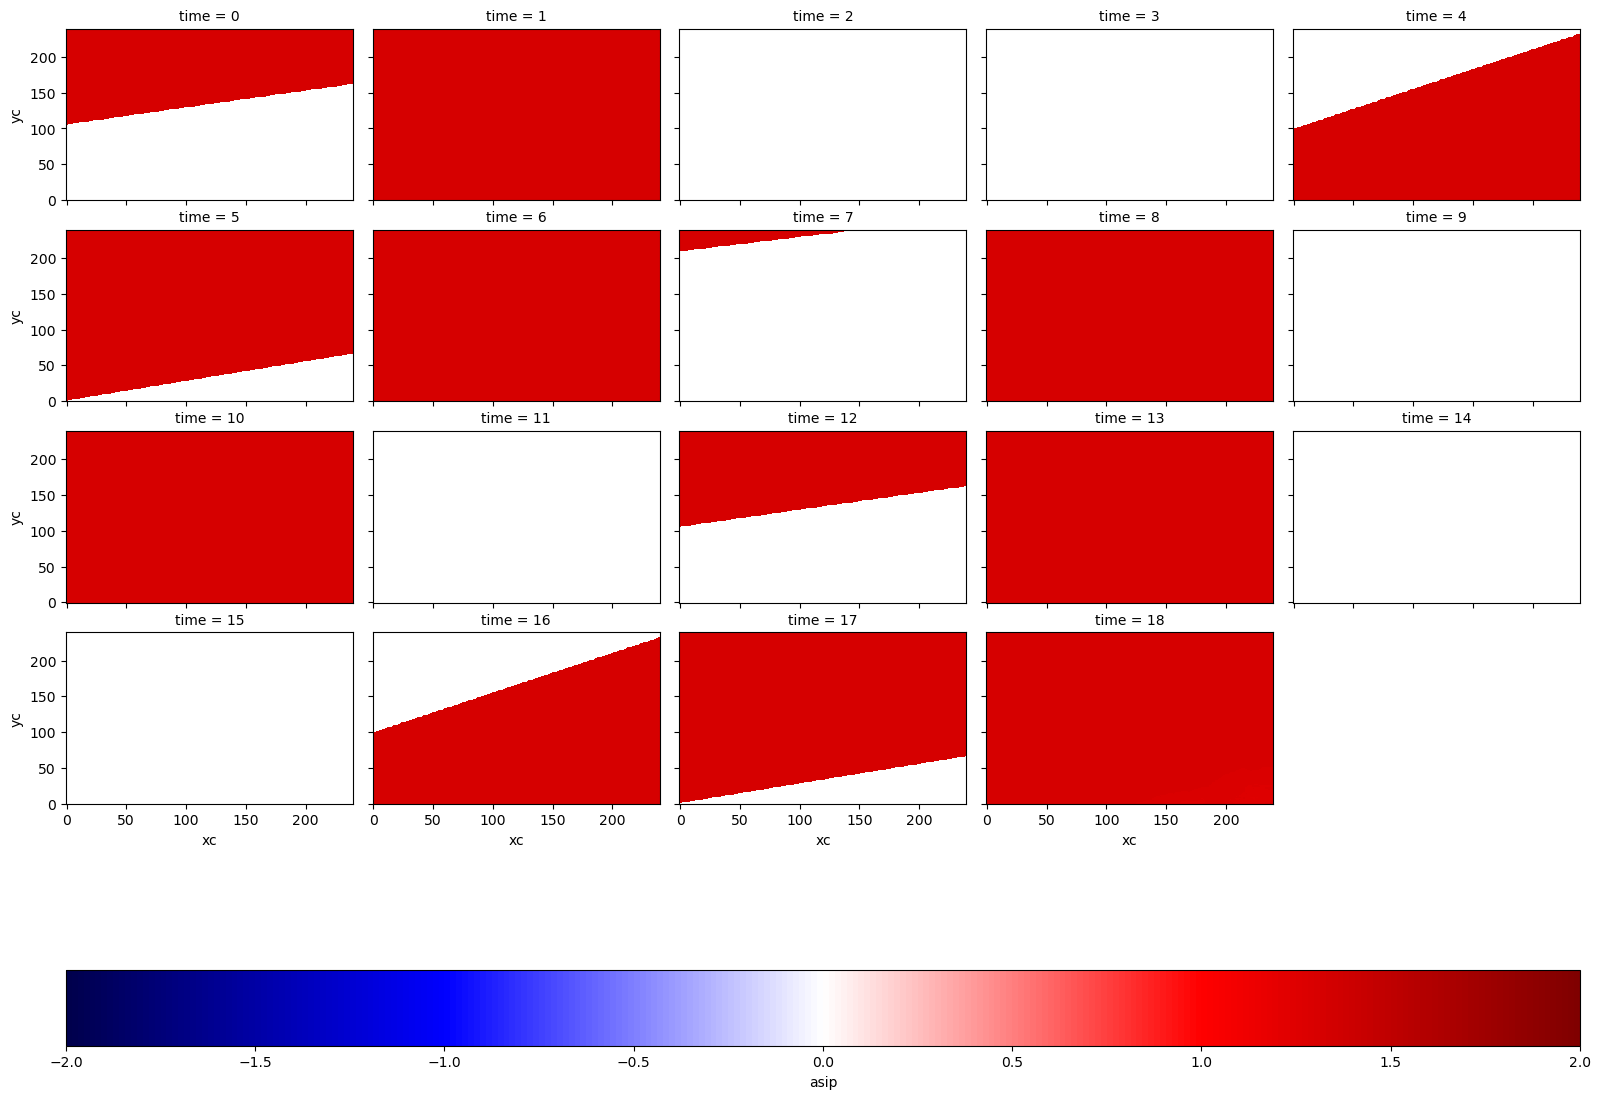

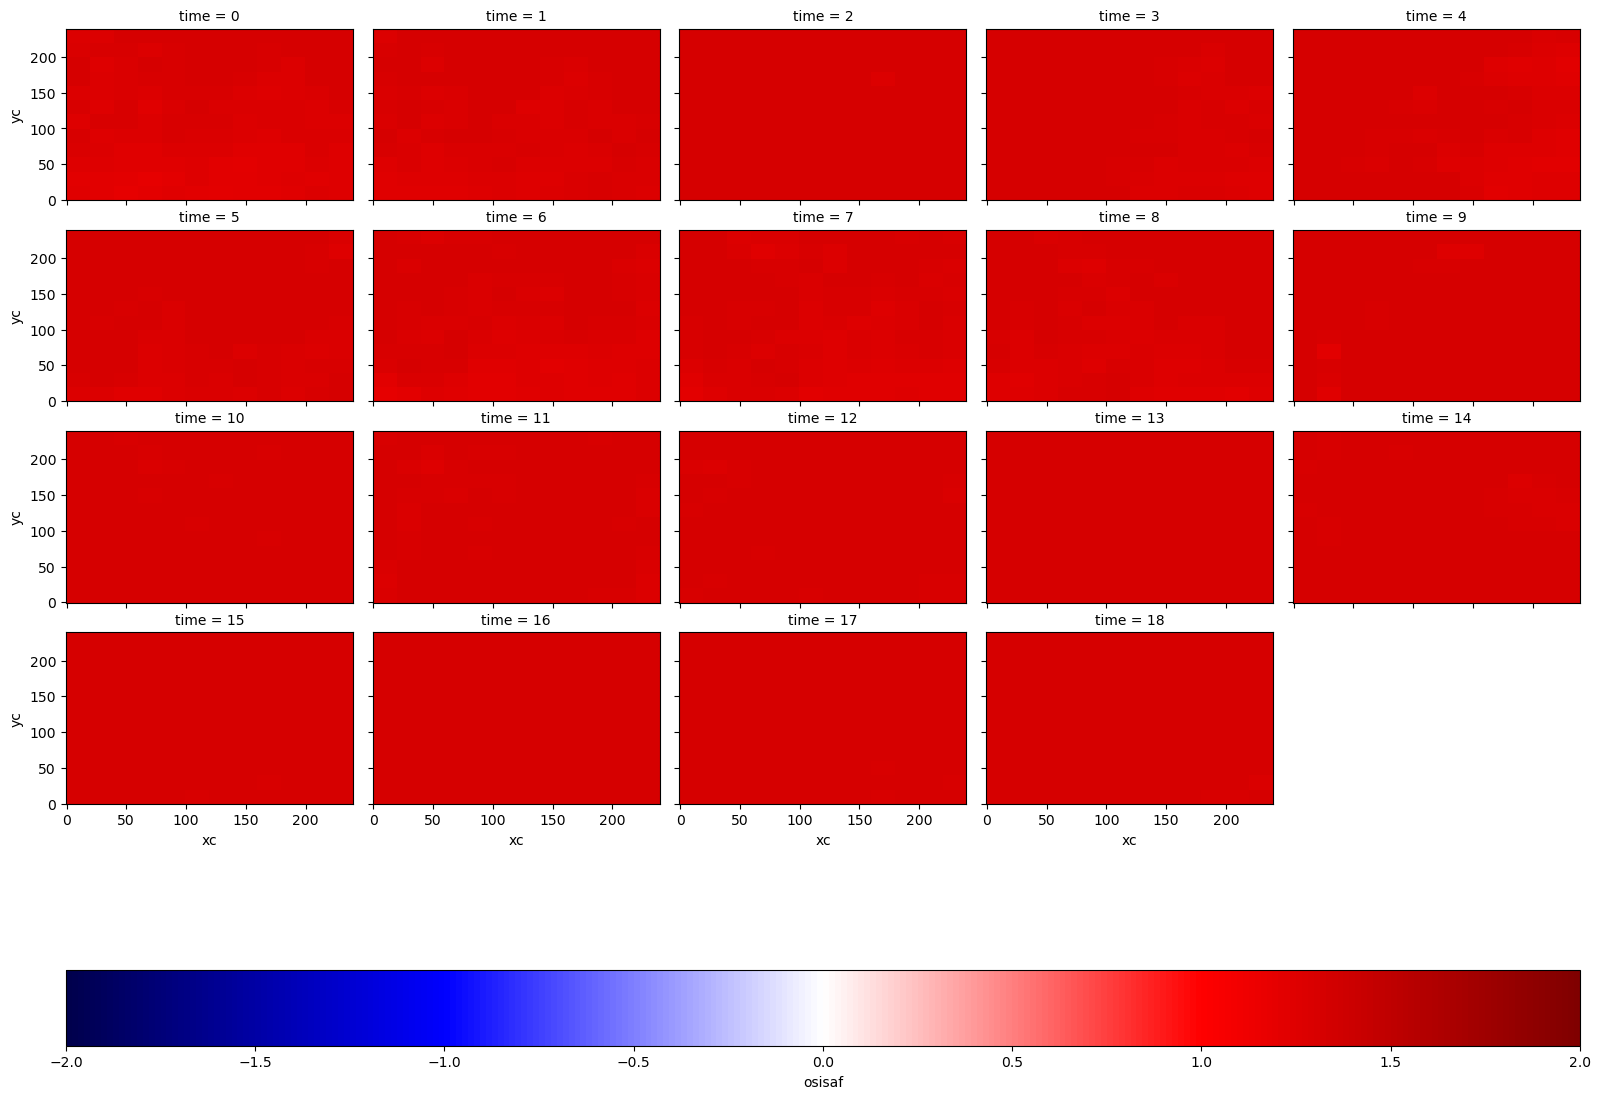

tensor(18.2152, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(353.8207, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(16.8825, device='cuda:0', grad_fn=<MulBackward0>)


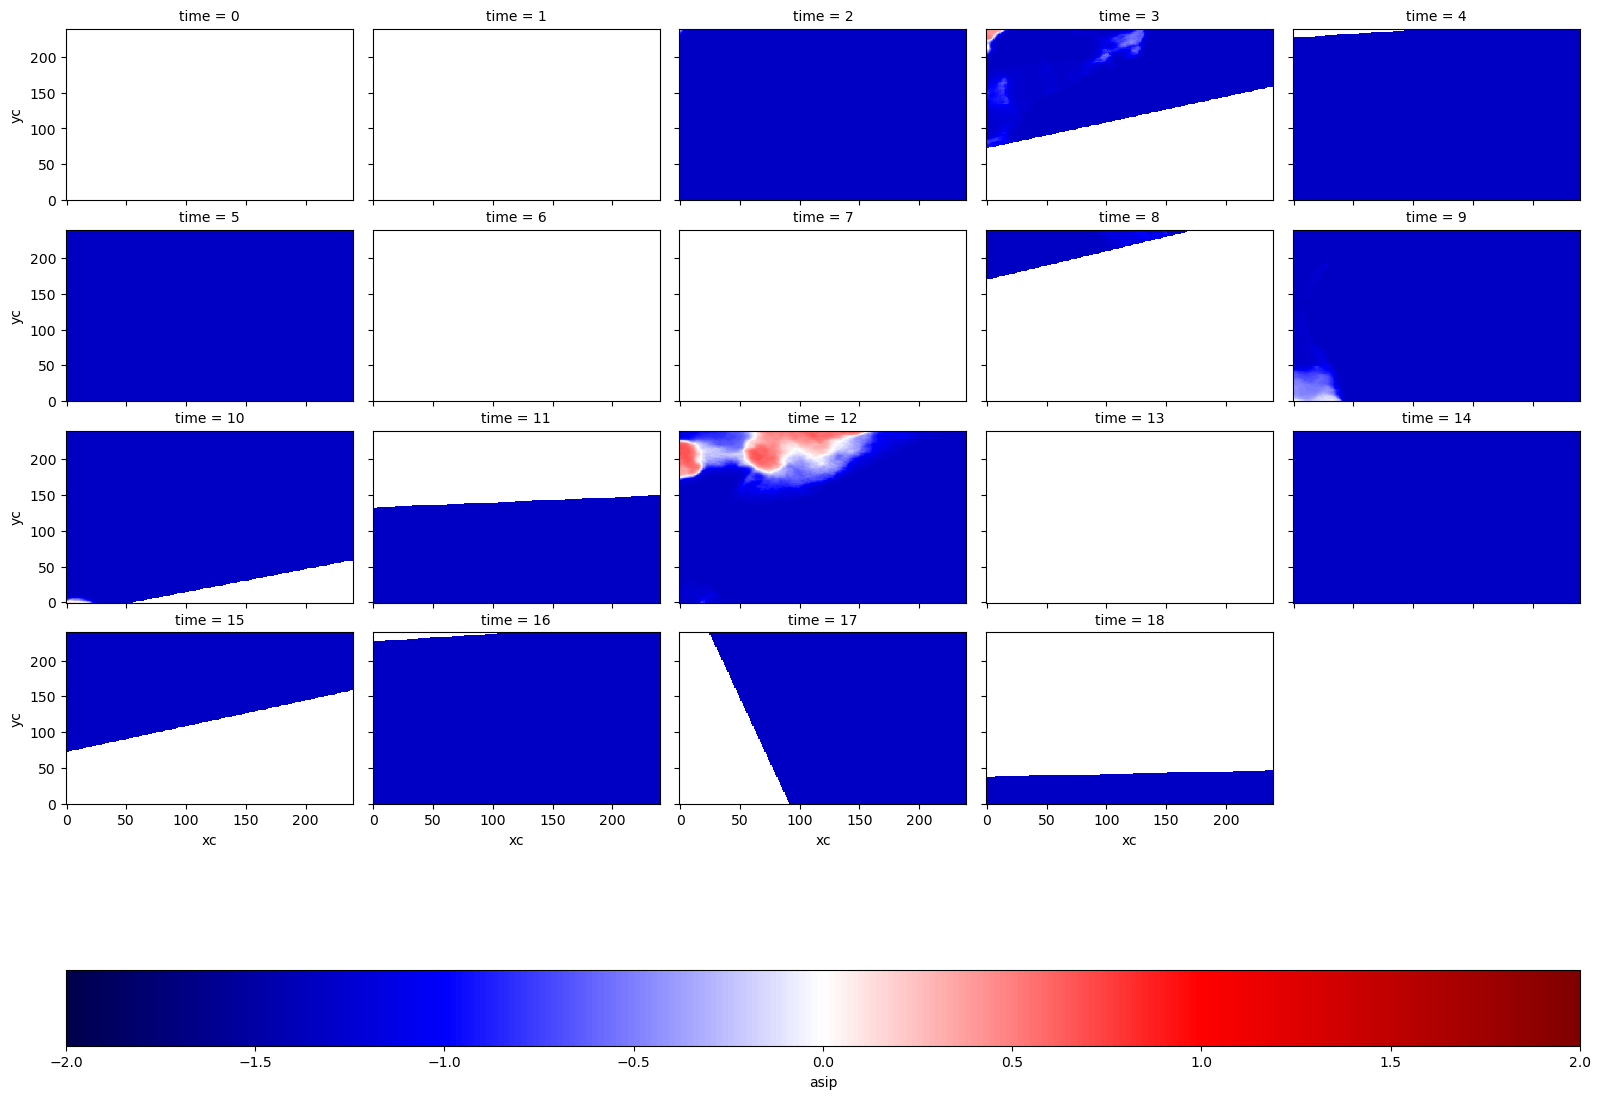

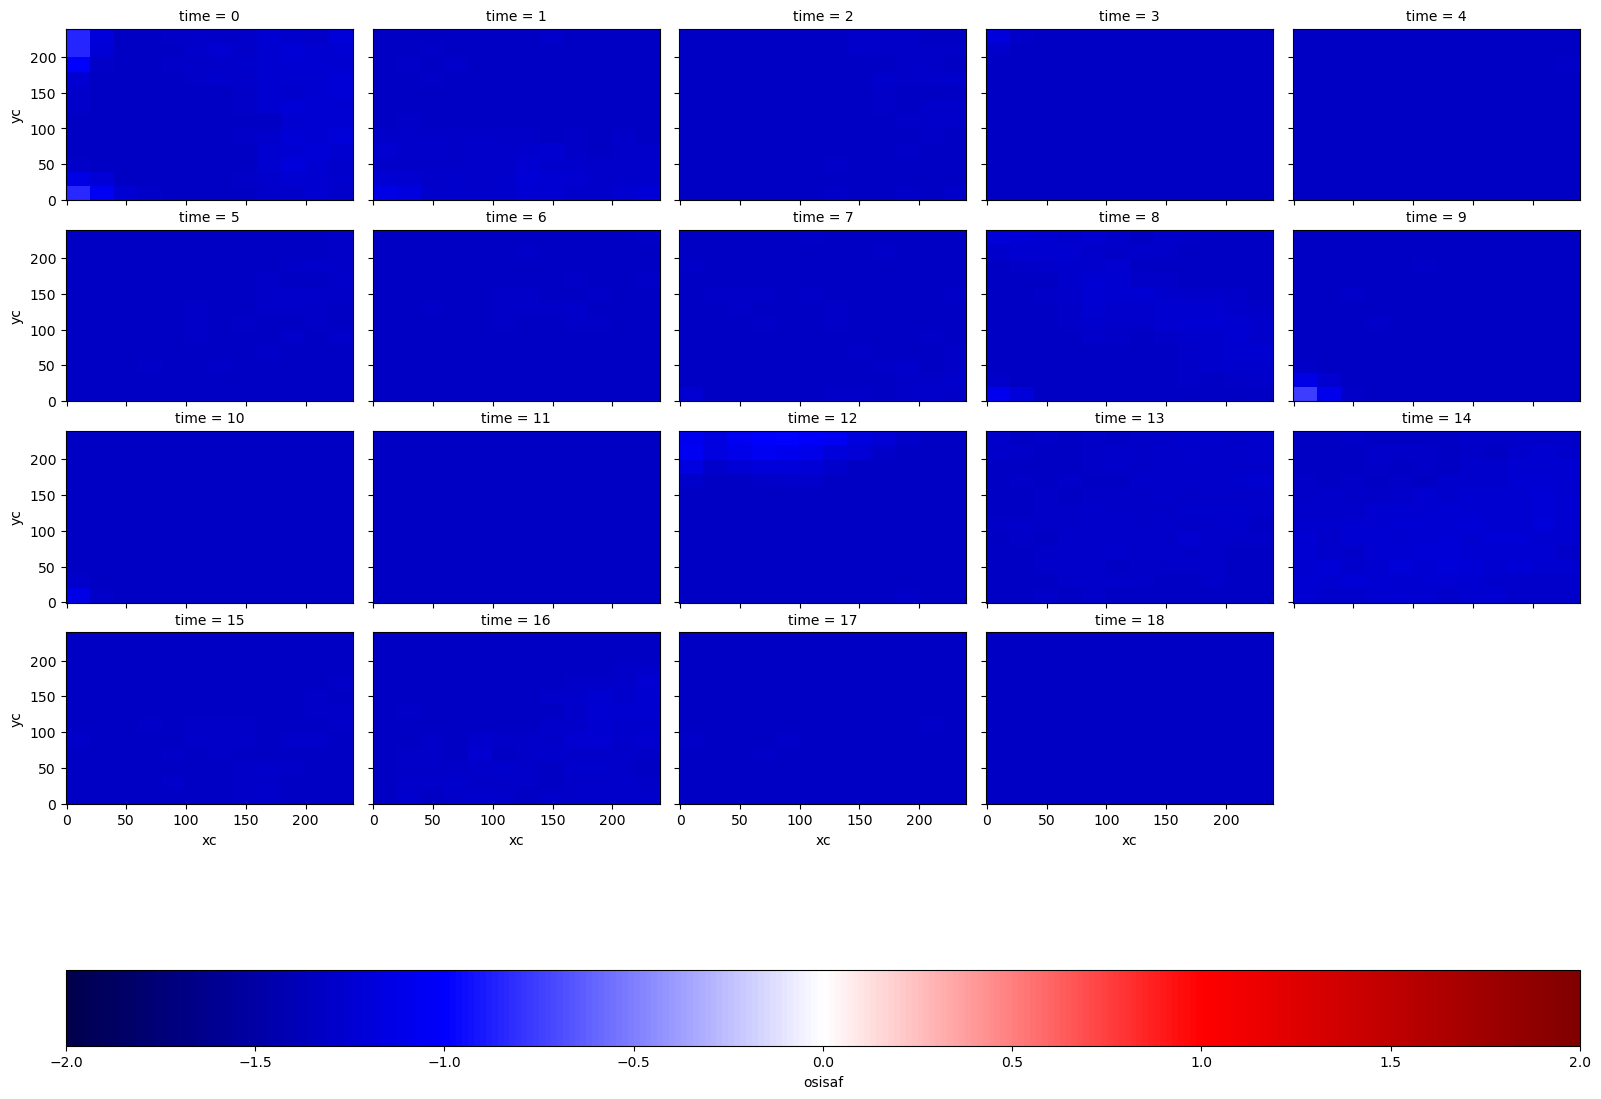

tensor(18.1507, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(294.5938, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(27.0696, device='cuda:0', grad_fn=<MulBackward0>)


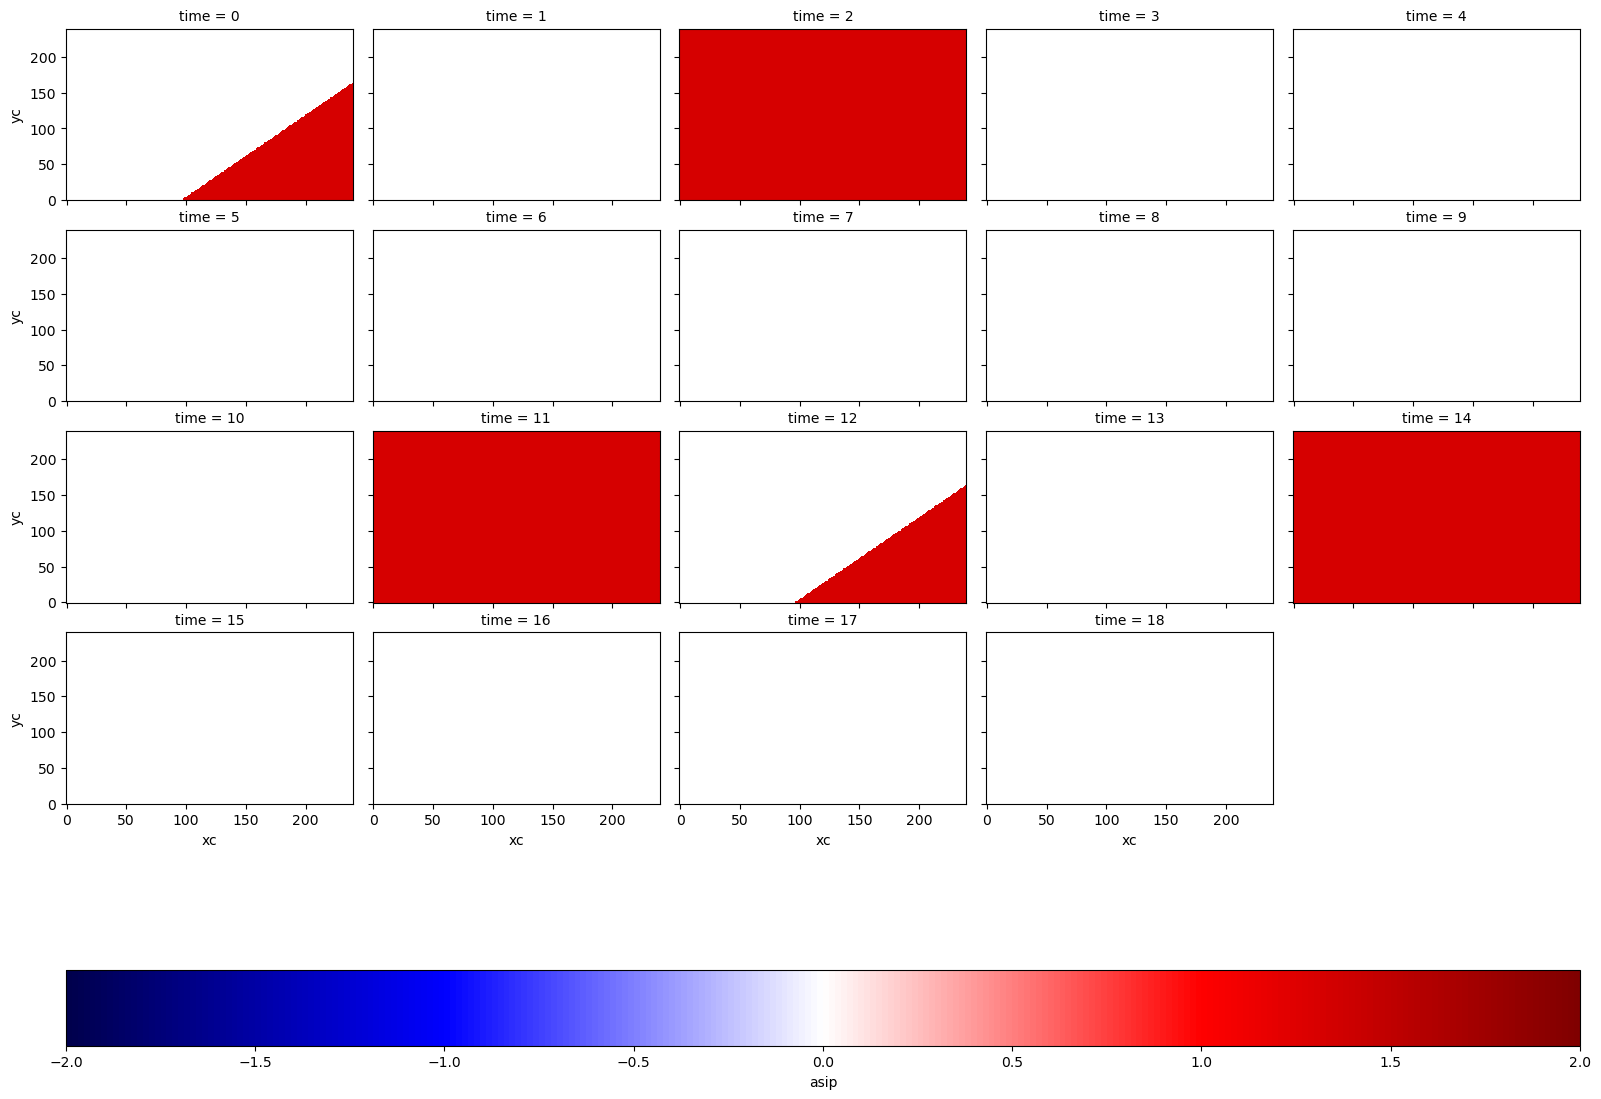

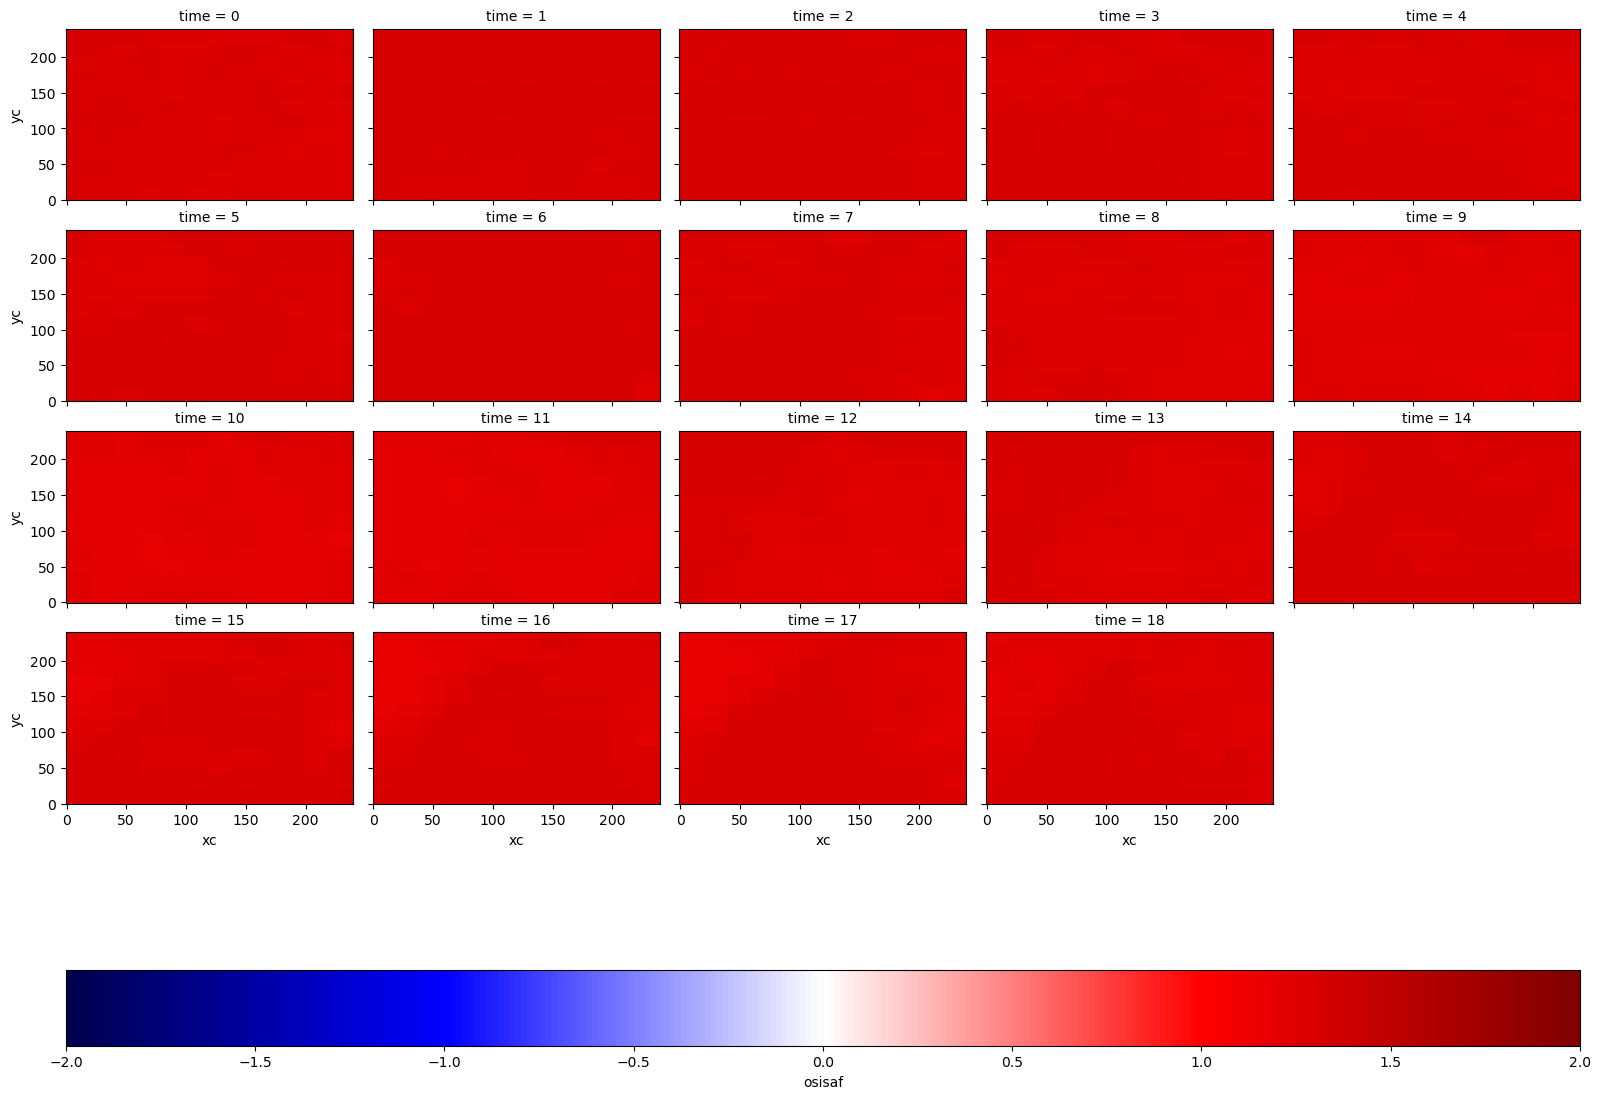

tensor(17.0043, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(221.4571, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(12.1038, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
#@title Training (double click to expand or collapse)

from IPython.display import clear_output
from torch.optim import Adam
from tqdm.autonotebook import tqdm
from kornia.filters import box_blur

n_epochs =  10#@param {'type':'integer'}
## learning rate
lr = 1e-3 #@param {'type':'number'}

optimizer = Adam(
        [
            {"params": solver.parameters(), "lr": lr}
        ],
    )

def remove_useless_patches(batch):

    def nanvar(tensor, dim=None, keepdim=False):
        tensor_mean = tensor.nanmean(dim=dim, keepdim=True)
        output = (tensor - tensor_mean).square().nanmean(dim=dim, keepdim=keepdim)
        return output
    
    idx = []
    for i in range(len(batch.tgt)):
        # keep the patch if not full of NaN or not full of ice/water (var=0)
        if ( (batch.tgt[i].isfinite().float().mean() != 0) and (nanvar(batch.coarse[i])!=0) ):
            idx.append(i)
    if len(idx)>0:
        batch = batch._replace(input=batch.input[idx])
        batch = batch._replace(tgt=batch.tgt[idx])
        batch = batch._replace(coarse=batch.coarse[idx])
    else:
        batch = None
    return batch

tqdm_epoch = tqdm(range(n_epochs))
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for batch in data_loader:
    batch = remove_useless_patches(batch)
    if batch is None:
        continue
    x = batch.tgt
    if x.isfinite().float().mean() < 0.08:
        continue
    p = xr.Dataset(data_vars={'asip':(('time','yc','xc'),batch.tgt[0,:,:,:].detach().cpu().numpy()),
                              'osisaf':(('time','yc','xc'),batch.coarse[0,:,:,:].detach().cpu().numpy())},
           coords={'time':np.arange(19),
                   'xc':np.arange(240),
                   'yc':np.arange(240)})
    p.asip.plot(#transform=ccrs.PlateCarree(),
                                        col='time',col_wrap=5,
                                        vmin=-2, vmax=2,
                                        #subplot_kws={'projection': map_proj},
                                        add_colorbar=True,
                                        cmap=plt.cm.seismic,
                                        cbar_kwargs=dict(orientation='horizontal'))
    plt.show()
    p.osisaf.plot(#transform=ccrs.PlateCarree(),
                                        col='time',col_wrap=5,
                                        vmin=-2, vmax=2,
                                        #subplot_kws={'projection': map_proj},
                                        add_colorbar=True,
                                        cmap=plt.cm.seismic,
                                        cbar_kwargs=dict(orientation='horizontal'))

    plt.show()
    batch = batch._replace(input=batch.input.nan_to_num().to(device))
    batch = batch._replace(tgt=batch.tgt.to(device))
    batch = batch._replace(coarse=batch.coarse.nan_to_num().to(device))
    loss, out = step(batch)
    #print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(solver.state_dict(), '../../ckpt/DMI/ASIP_OSISAF/ckpt_L4.pth')

In [9]:
#ckpt = torch.load('/homes/m19beauc/4dvarnet-starter/ckpt/DMI/SST/sst_dmi_all_baltic_wgeo_linweight.ckpt', map_location=device)
ckpt = torch.load('/homes/m19beauc/4dvarnet-starter/ckpt/DMI/SST/sst_dmi_baltic_dm3.ckpt', map_location=device)
solver_weights = {k[7:]: v for k, v in ckpt["state_dict"].items() if k.startswith("solver.")}
solver.load_state_dict(solver_weights)

<All keys matched successfully>

In [10]:
k=56
test_batch = next(itertools.islice(test_dataloader, k, None))
test_batch_ = test_batch
test_batch_ = test_batch_._replace(input=test_batch_.input.nan_to_num().to(device))
test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.nan_to_num().to(device))
test_batch_._replace(mask=test_batch_.mask.nan_to_num().to(device))
# 4DVarNets scheme  
out = solver(test_batch_)

/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/torch/autograd/__init__.py:276: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 802: system not yet initialized (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
